In [2]:
#@title Cài đặt kiểm tra môi trường và tải mã nguồn để lấy dữ liệu
# Kiểm tra hiện tại có phải đang ở trong colaboratory hay không
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !git clone https://github.com/HoanChan/TableVision.git TableVision
else:
    print("Running on Local")

Running on Local


<Figure size 1000x2000 with 0 Axes>

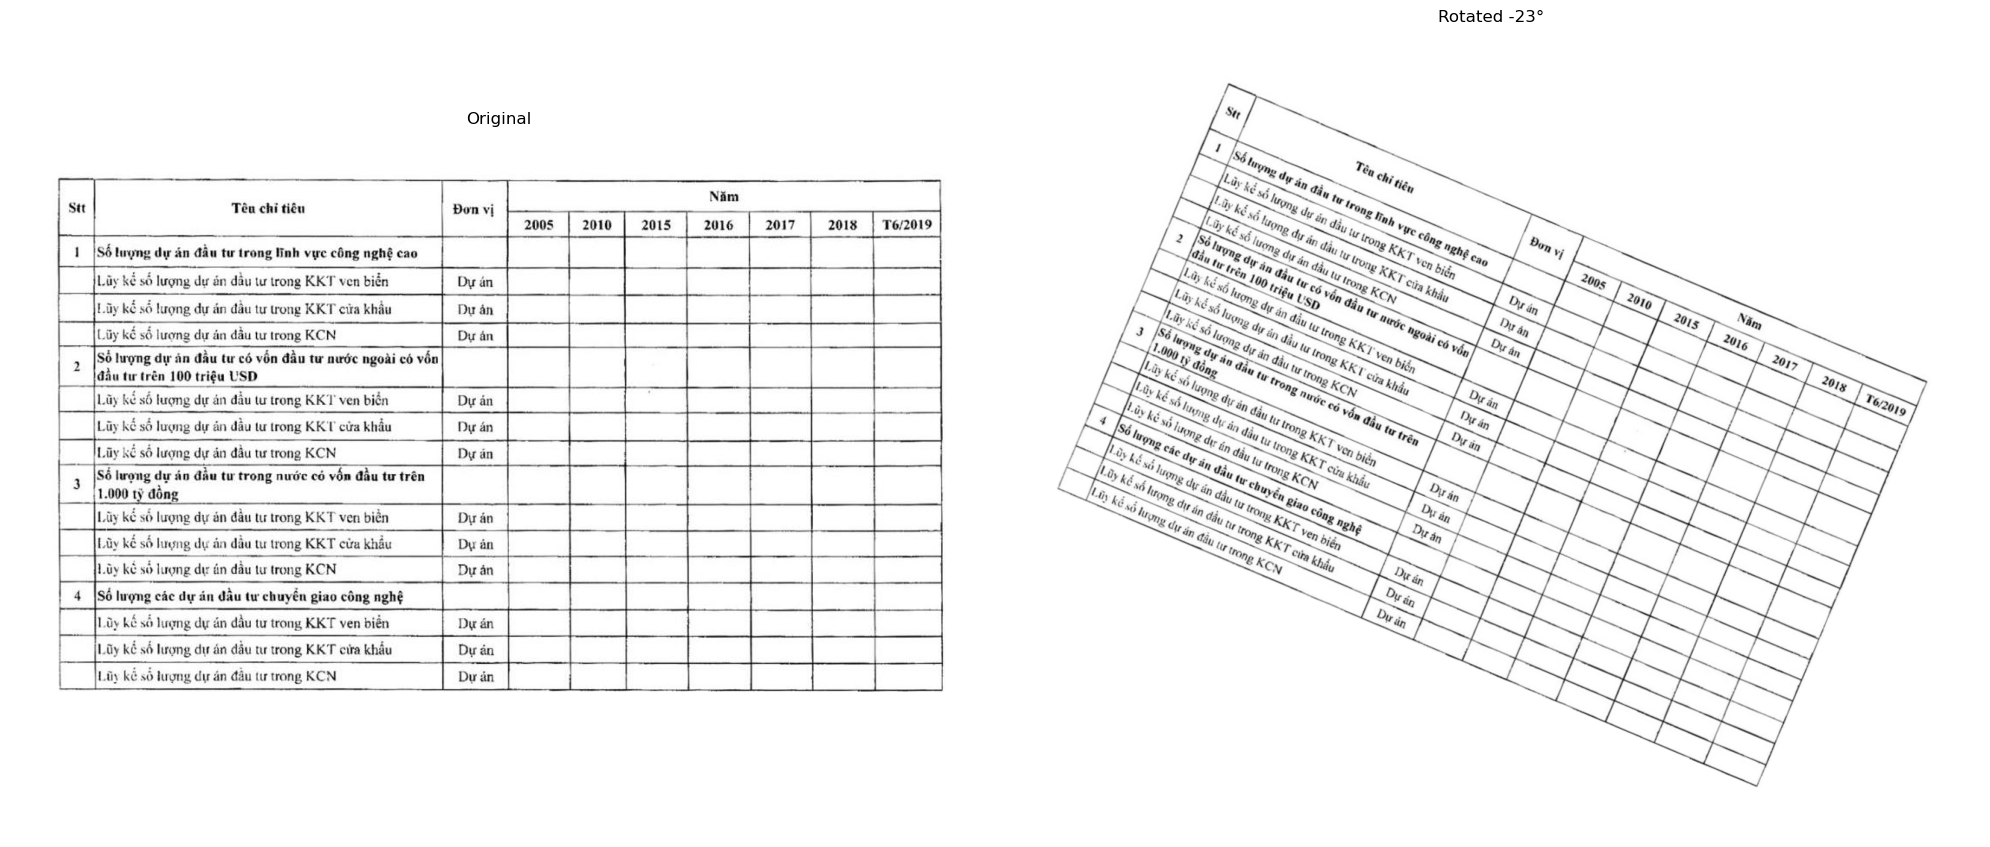

In [3]:
#@title Hàm hiển thị ảnh và xoay ảnh ngẫu nhiên để tạo đầu vào
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt
def display_images_with_labels(image_labels, layout, size=(10, 10), show_axis=True):
    """
    Hiển thị các ảnh cùng với nhãn bằng matplotlib.pyplot.

    Tham số:
    - image_labels: Danh sách các tuple (ảnh, nhãn) cần hiển thị.
    - layout: Tuple (rows, columns) chỉ định cách bố trí ảnh trên lưới.
    - size: Tuple (width, height) chỉ định kích thước của mỗi ảnh.
    - show_axis: Bool, xác định xem có hiển thị trục hay không.
    """
    rows, columns = layout
    total_images = len(image_labels)

    # Tính số lượng ảnh cần thêm vào để điền đầy lưới
    num_padding = rows * columns - total_images

    # Thêm ảnh trống vào danh sách nếu cần
    image_labels += [(None, None)] * num_padding

    # Tạo subplot với tỉ lệ cố định
    fig, axes = plt.subplots(rows, columns, figsize=(size[0]*columns, size[1]*rows), subplot_kw={'aspect': 'equal'})

    # Hiển thị ảnh cùng với nhãn trên các ô subplot
    for i, (image, label) in enumerate(image_labels):
        ax = axes.flat[i]
        if image is not None:
            # Chuyển đổi màu từ BGR sang RGB để hiển thị đúng
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax.imshow(image_rgb)
        if label is not None:
            ax.set_title(label)
        if not show_axis:
            ax.axis("off")

    plt.tight_layout()
    plt.show()
    
def rotate_image(image, angle):
    # Xác định kích thước ảnh
    height, width = image.shape[:2]

    # Tính toán ma trận xoay
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)

    # Tính toán kích thước mới của ảnh sau khi xoay
    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])
    new_width = int((height * sin) + (width * cos))
    new_height = int((height * cos) + (width * sin))

    # Cập nhật ma trận xoay để điều chỉnh kích thước ảnh
    rotation_matrix[0, 2] += (new_width / 2) - (width / 2)
    rotation_matrix[1, 2] += (new_height / 2) - (height / 2)

    # Thực hiện xoay và điều chỉnh kích thước ảnh
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_width, new_height), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    return rotated_image

prePath = "/content/TableVision/" if IN_COLAB else ""
image = cv2.imread(prePath + "sample/vn1.jpg")
angle = random.randint(-30, 30)
rotated_image = rotate_image(image, angle)
# thiết lập kích thước hiển thị ảnh
plt.figure(figsize=(10, 20))
# hiển thị ảnh gốc và ảnh đã xoay
display_images_with_labels([(image, "Original"), (rotated_image, f"Rotated {str(angle)}°")], (1, 2), show_axis=False)

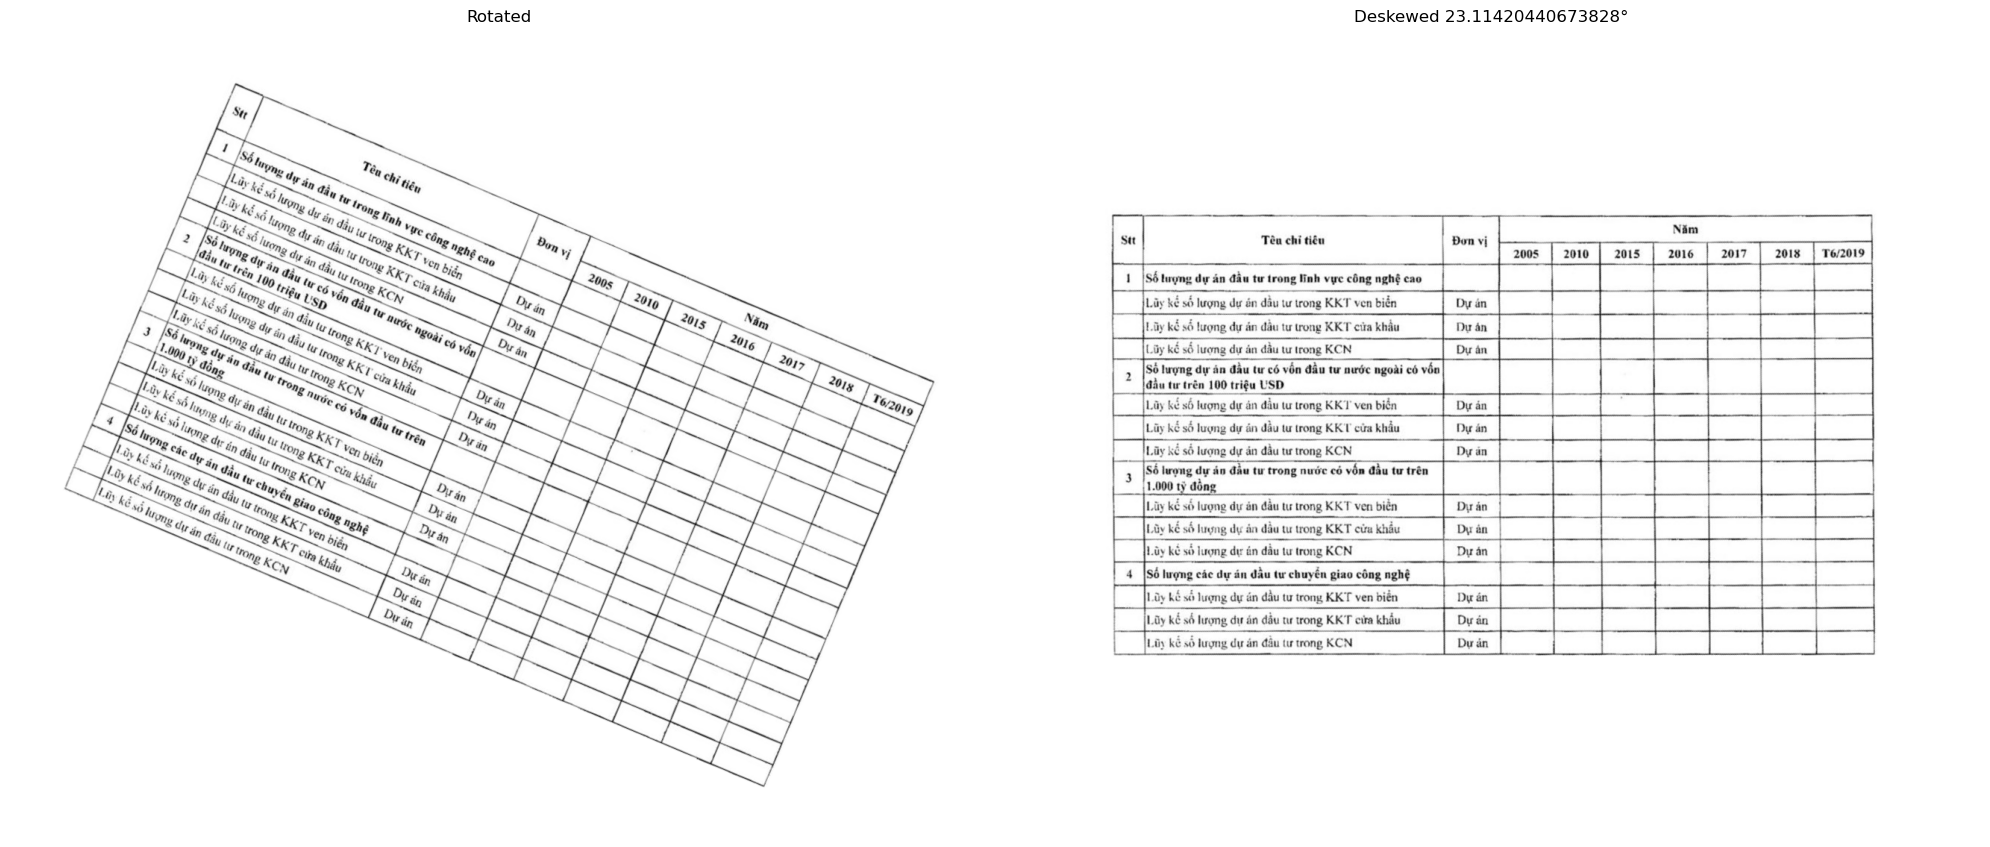

In [4]:
#@title Làm chỉnh sửa góc nghiêng
def deskew_image(image):
    """
    Chỉnh sửa góc nghiêng của ảnh.

    Tham số:
    - image: Ảnh cần chỉnh sửa góc nghiêng.

    Kết quả:
    - deskewed_image: Ảnh đã chỉnh sửa góc nghiêng.
    - angle: Góc nghiêng của ảnh.
    """
    # Làm mờ ảnh để loại bỏ nhiễu
    blur_image = cv2.medianBlur(image, 5)

    # Chuyển đổi sang ảnh grayscale và đảo ngược màu
    grayscale_image = cv2.bitwise_not(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

    # Xác định ngưỡng 
    _, threshold_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Tìm tọa độ các điểm ảnh khác 0 (điểm ảnh màu trắng)
    coordinates = np.column_stack(np.where(threshold_image > 0))

    # Xác định góc xoay của ảnh
    angle = cv2.minAreaRect(coordinates)[-1]
    if angle < -45:
        angle = -(90 + angle)
    elif angle > 45:
        angle = 90 - angle
    else:
        angle = -angle

    # Xoay ảnh để chỉnh sửa góc nghiêng và điều chỉnh kích thước ảnh để xoay không bị cắt ảnh
    height, width = blur_image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return deskewed_image, angle

image_ok, calc_angle = deskew_image(rotated_image)
display_images_with_labels([(rotated_image, "Rotated"), (image_ok, f"Deskewed {str(calc_angle)}°")], (1, 2), show_axis=False)

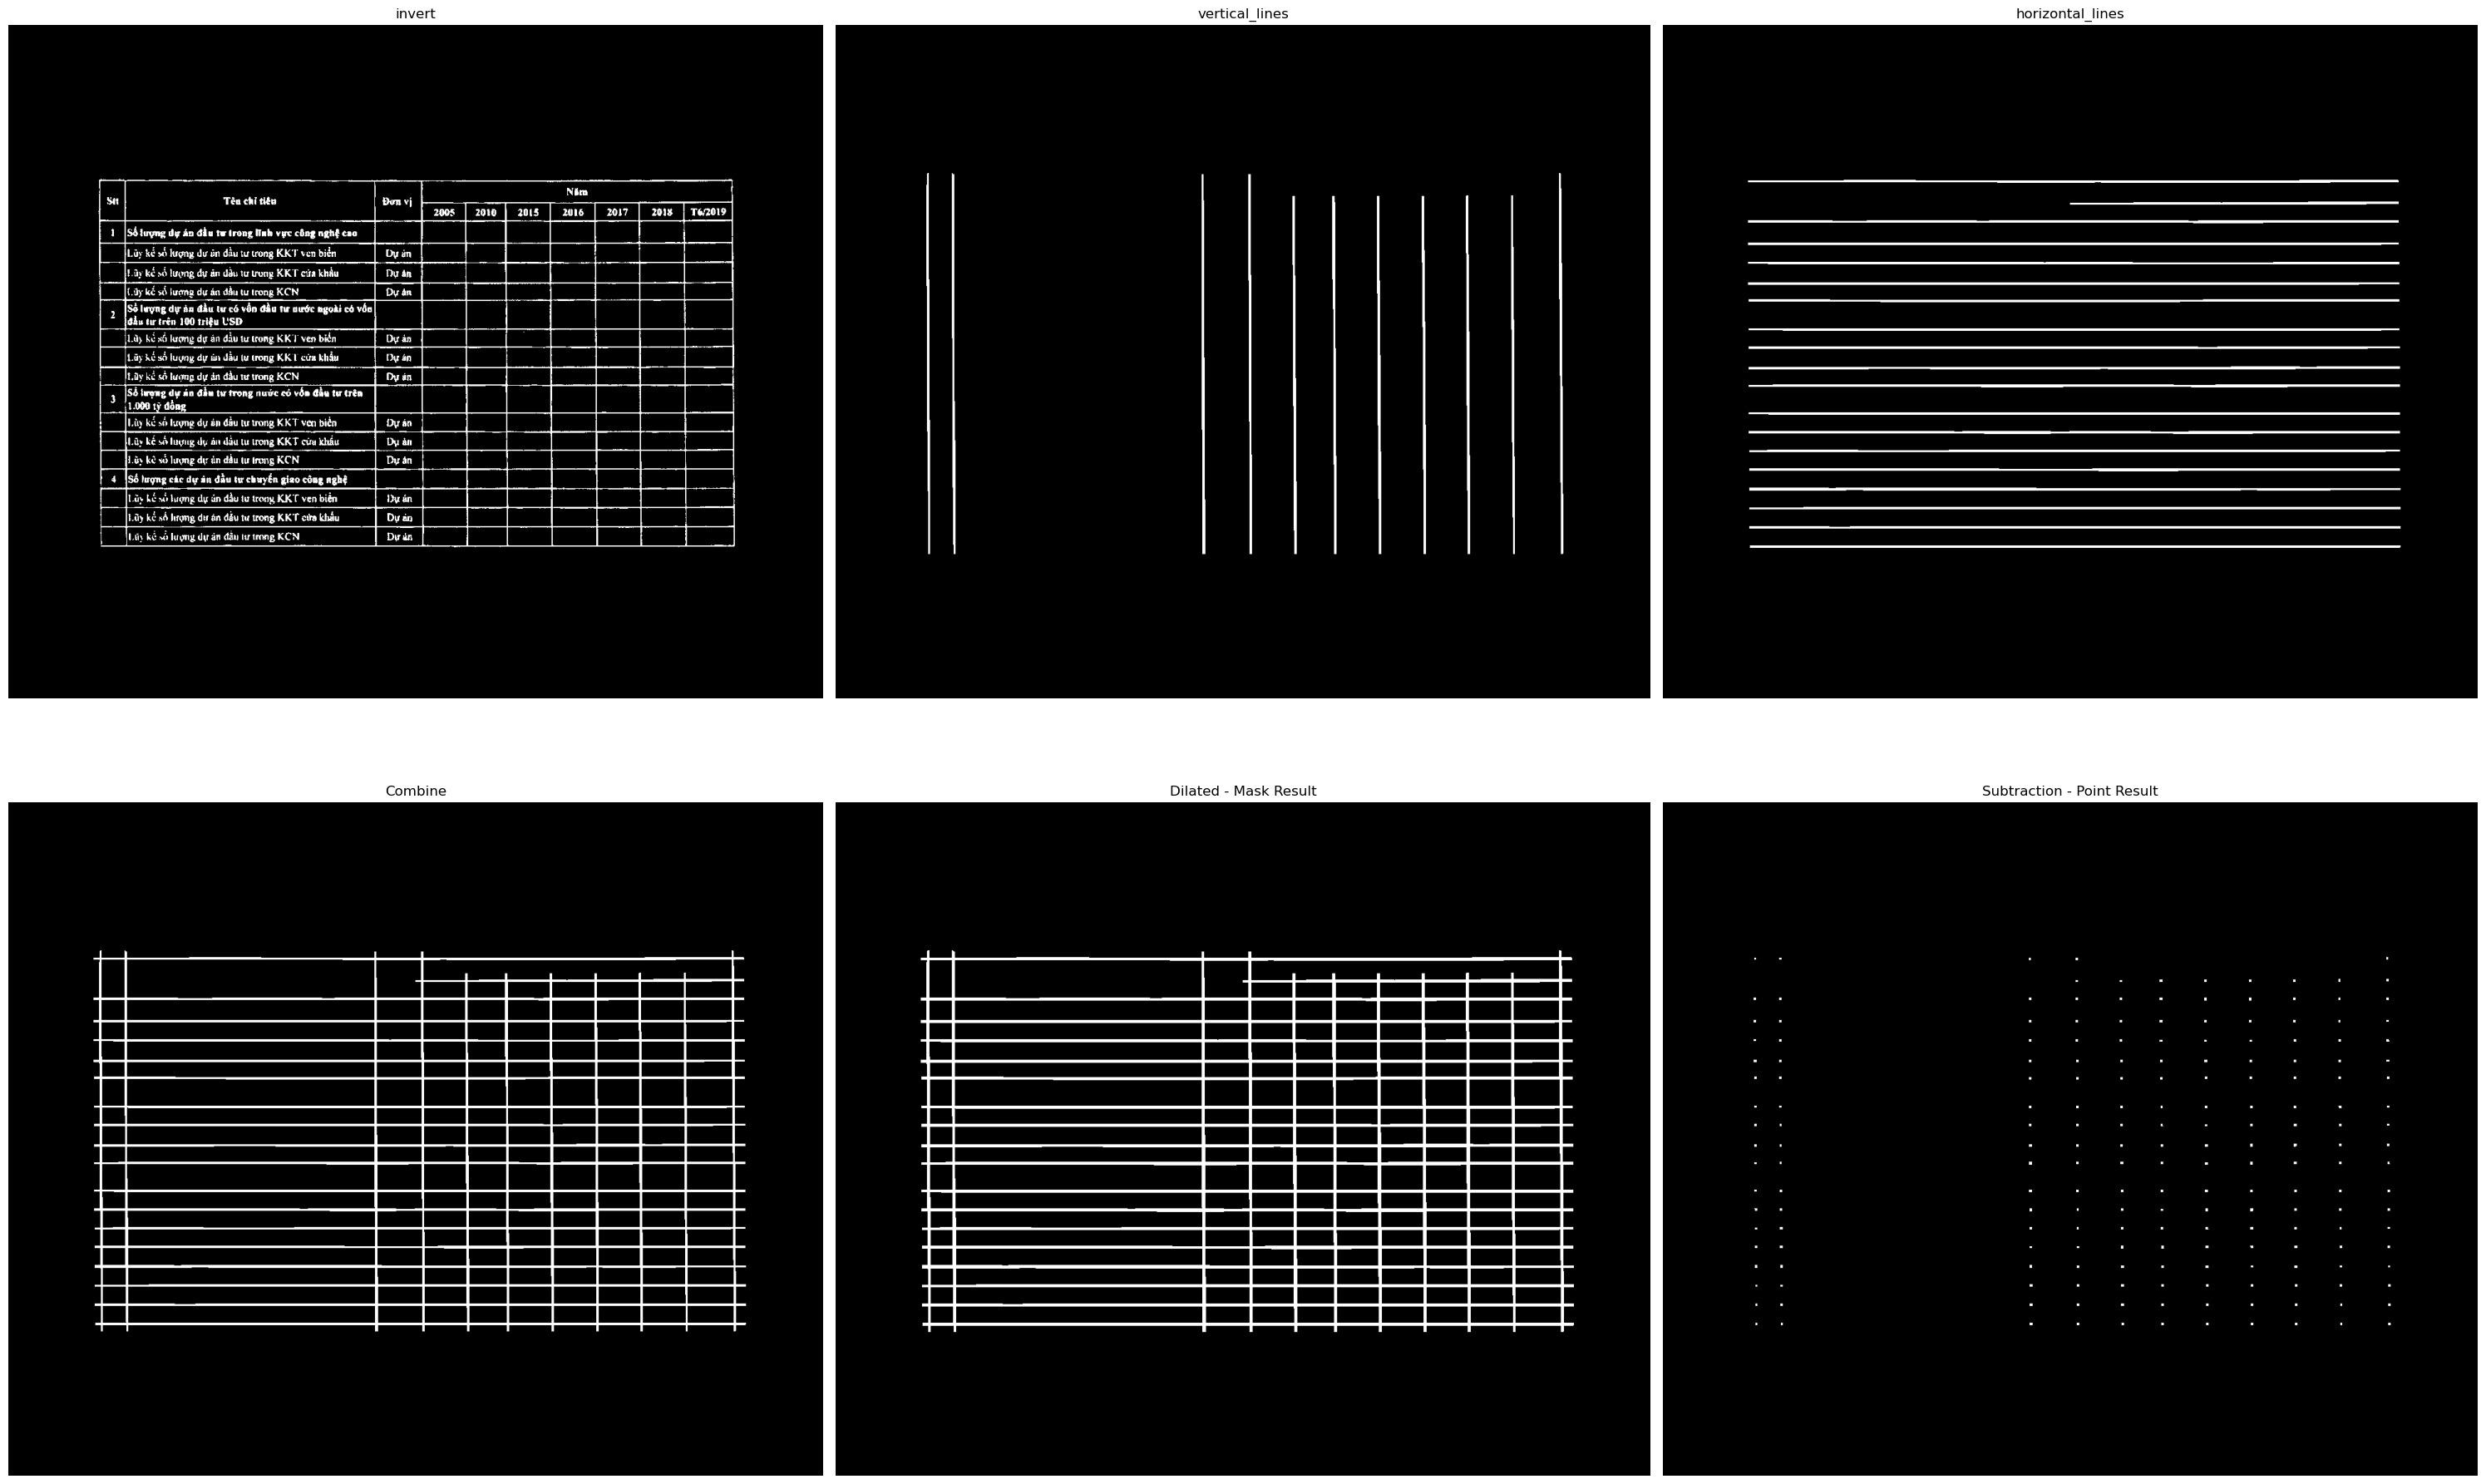

In [5]:
#@title Nhận diện cấu trúc bảng

def detect_lines(img_bin, fixkernel, detectkernel):
    """
    Phát hiện các đường thẳng trong ảnh bằng cách sử dụng các kernel được chỉ định.
    Cụ thể, ảnh được lấp đầy các khoảng trống với fixkernel.
    Sau đó loại bỏ các thành phần không phải đường thẳng với detectkernel.
    Cuối cùng là phục hồi lại như cũ với detectkernel.

    Tham số:
    - img_bin: Ảnh nhị phân.
    - fixkernel: Kernel được sử dụng để dilate (Bồi đắp các pixel màu trắng) để sửa lỗi.
    - detectkernel: Kernel được sử dụng để erode (Bào mòn các pixel màu trắng) và dilate nhằm giữ lại các đường.

    Kết quả:
    - result: Ảnh sau khi phát hiện các đường thẳng.
    """
    image_0 = cv2.dilate(img_bin, fixkernel, iterations=2)
    image_1 = cv2.erode(image_0, detectkernel, iterations=3)
    result = cv2.dilate(image_1, detectkernel, iterations=4)
    return result

def recognize_structure(img):
    """
    Nhận diện cấu trúc bảng trong ảnh.

    Tham số:
    - img: Ảnh cần nhận diện cấu trúc.

    Kết quả:
    - img_vh: Ảnh chứa thông tin về các đường kẻ dọc và ngang (mask).
    - img_sub: Ảnh chứa thông tin các điểm giao nhau của các đường dọc và ngang.
    - outImag: Danh sách các ảnh trung gian.
    """    
    outImag=[]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_height, img_width = img.shape
    # THRESH_OTSU là phương pháp tự động xác định ngưỡng dựa trên histogram của ảnh
    thresh, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    outImag.append((img_bin, 'invert'))

    # Giả sử bảng có tối đa 50 dòng và 50 cột
    kernel_len_ver = img_height // 50
    kernel_len_hor = img_width // 50
    # Defining a vertical kernel to detect all vertical lines of image
    ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len_ver))

    # Defining a horizontal kernel to detect all horizontal lines of image
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len_hor, 1))

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

    vertical_lines = detect_lines(img_bin, kernel, ver_kernel)
    outImag.append((vertical_lines, 'vertical_lines'))

    horizontal_lines = detect_lines(img_bin, kernel, hor_kernel)
    outImag.append((horizontal_lines, 'horizontal_lines'))

    img_vh = cv2.bitwise_or(vertical_lines, horizontal_lines)
    outImag.append((img_vh, 'Combine'))

    img_vh = cv2.dilate(img_vh, kernel, iterations=1)
    outImag.append((img_vh, 'Dilated - Mask Result'))

    img_sub = cv2.bitwise_and(vertical_lines, horizontal_lines)
    outImag.append((img_sub, 'Subtraction - Point Result'))

    return img_vh, img_sub, outImag

mask, dots, outImag = recognize_structure(image_ok)
num_cols = 3
num_rows = len(outImag) // num_cols if len(outImag) % num_cols == 0 else len(outImag) // num_cols + 1
display_images_with_labels(outImag, (num_rows, num_cols), show_axis=False)

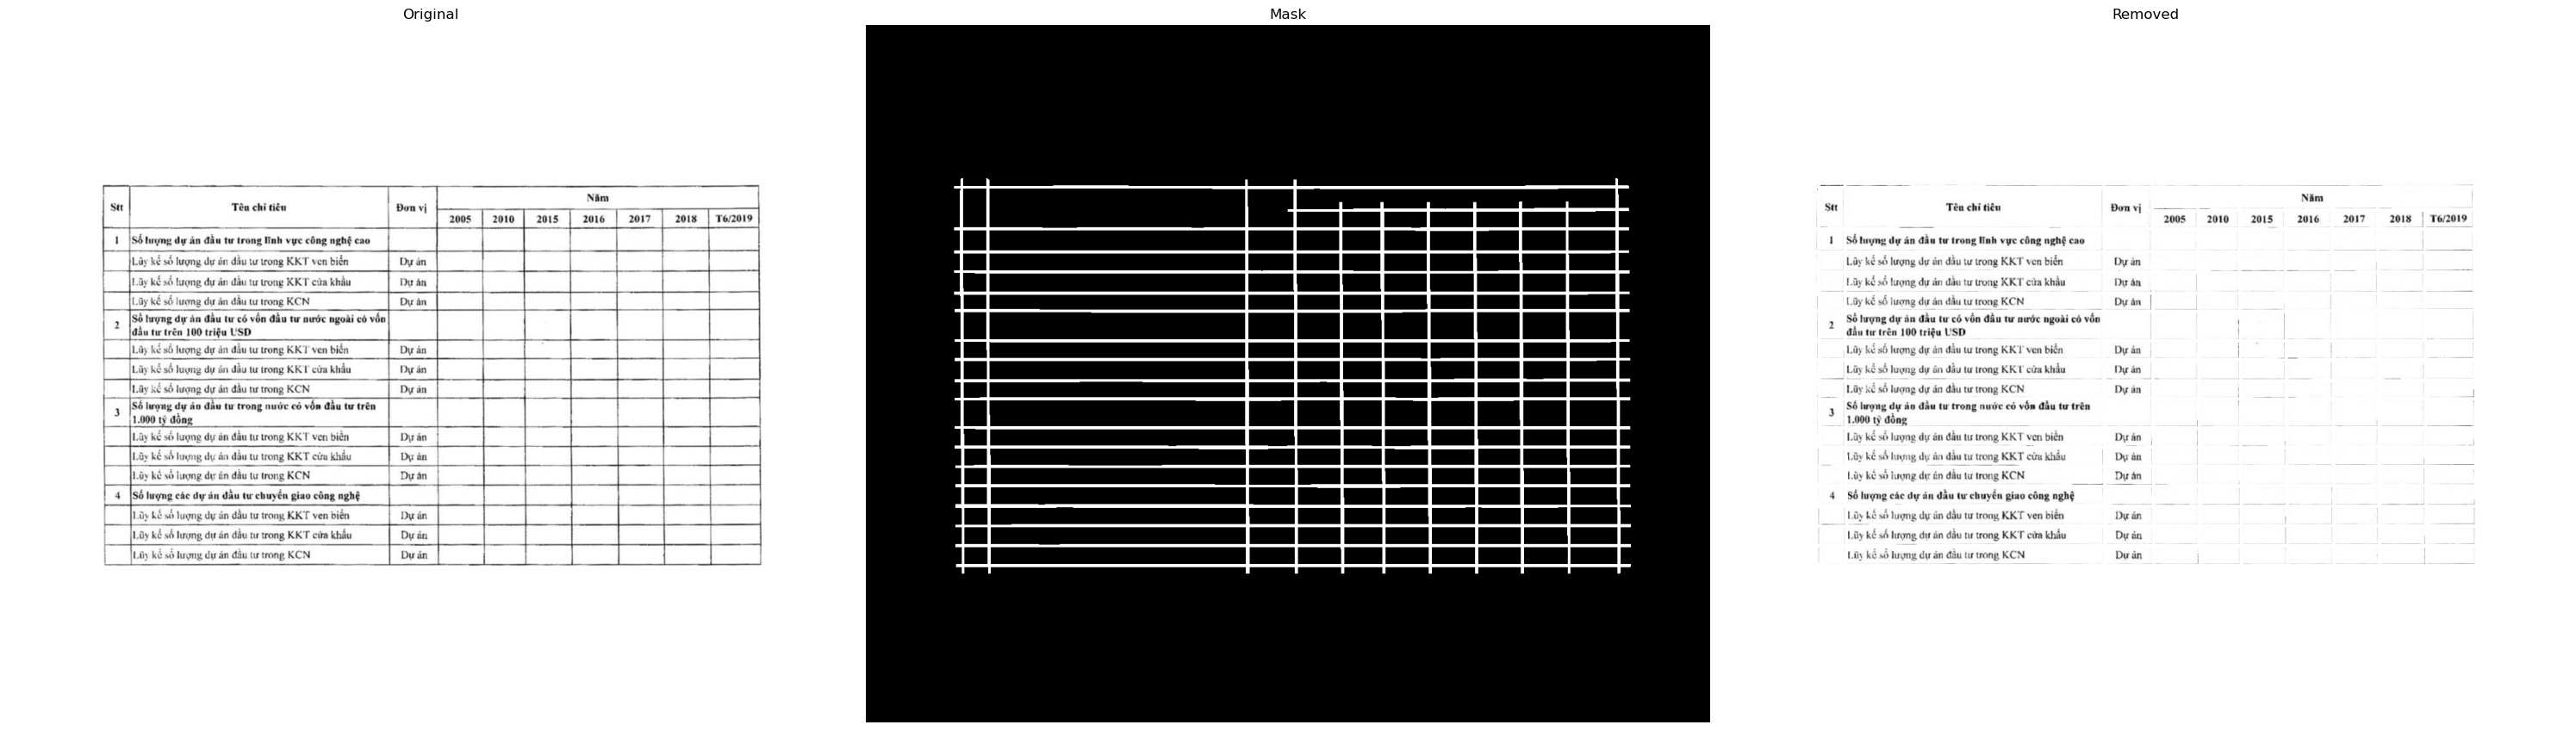

In [6]:
#@title Loại bỏ các vùng không cần thiết (cụ thể ở đây chính là các đường kẻ dọc và ngang) - Để cắt các ô bảng
def remove_regions(image, mask):
    """
    Loại bỏ các vùng trong ảnh sử dụng mặt nạ.

    Tham số:
    - image: Ảnh gốc.
    - mask: Mặt nạ có kích thước giống với ảnh, với giá trị 0 ở các vùng cần loại bỏ và 1 ở các vùng khác.

    Trả về:
    - Ảnh đã loại bỏ các vùng cần loại bỏ.
    """
    masked_image = image.copy()
    masked_image[mask != 0] = [255, 255, 255]
    return masked_image

image_removed = remove_regions(image_ok, mask)
display_images_with_labels([(image_ok, "Original"), (mask,'Mask'), (image_removed, "Removed")], (1, 3), show_axis=False)

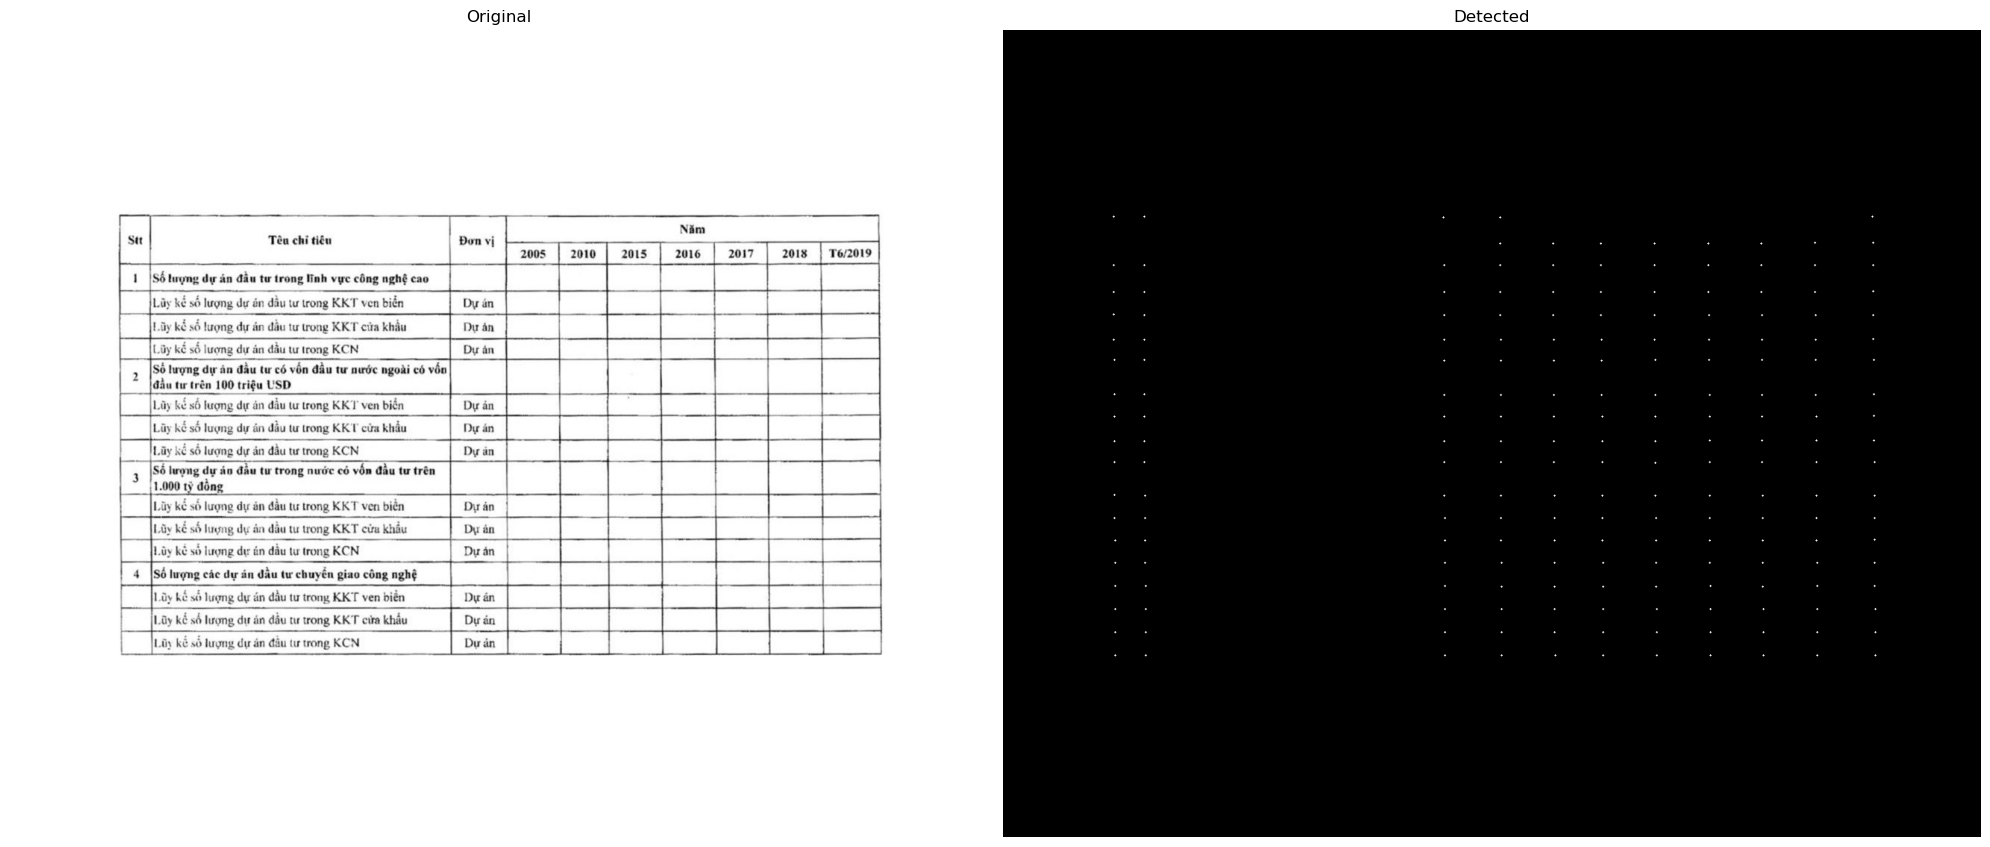

In [7]:
#@title Dựa vào ảnh điểm giao của các đường kẻ dọc và ngang để tìm chính xác toạ độ các điểm này

def findCenters(img_bin):
    """
    Tìm trọng tâm của các bbox trong ảnh. Thực hiện bồi đắp theo kernel 3x3, sao đó tìm bbox và tính center.

    Tham số:
    - img_bin: Ảnh nhị phân.

    Trả về:
    - centers: Danh sách các tọa độ trọng tâm của các bbox.
    """
    kernel = np.ones((3,3),np.uint8)
    img_bin = cv2.dilate(img_bin, kernel, iterations=1)
    contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    centers = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        centers.append((x + w // 2, y + h // 2))
    return centers

centers = findCenters(dots)

# tạo 1 img mới, với kích thước bằng kích thước của img gốc, màu đen
# vẽ các trọng tâm của bbox lên img mới
def drawCenters(img, centers):
    img = np.zeros_like(img)
    for center in centers:
        cv2.circle(img, center, 1, (255, 255, 255), -1)
    return img

dots_img = drawCenters(image_ok, centers)
display_images_with_labels([(image_ok, "Original"), (dots_img, "Detected")], (1, 2), show_axis=False)

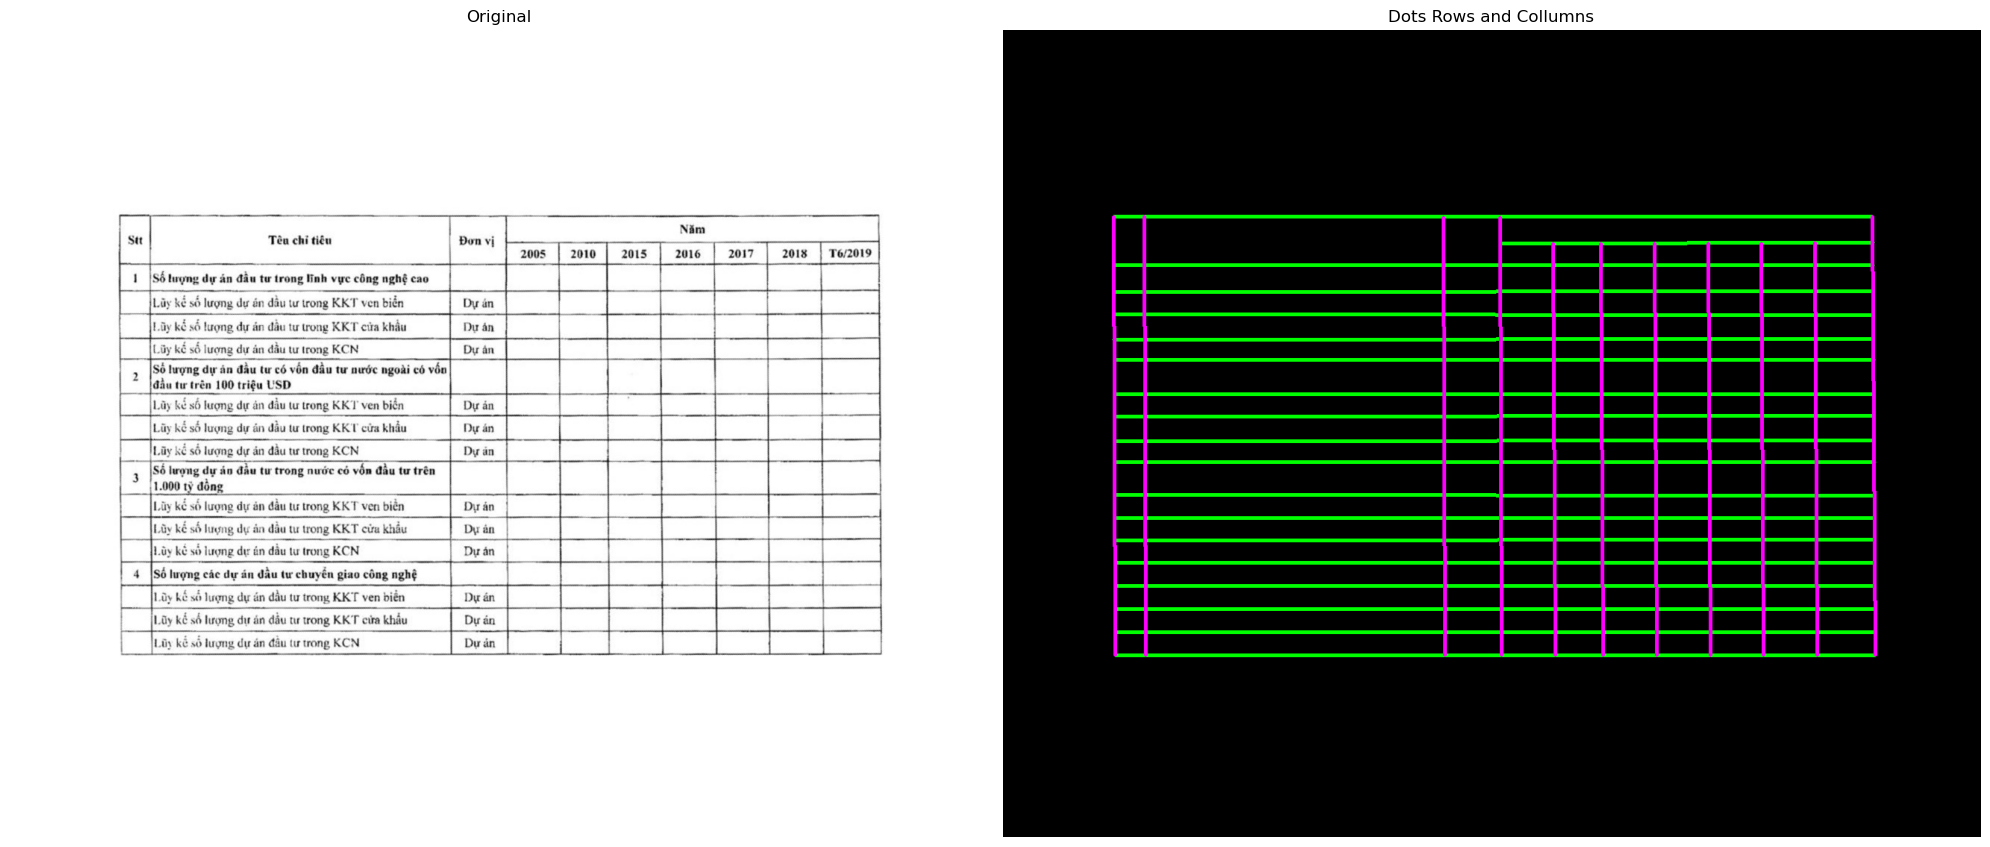

In [8]:
#@title Sắp xếp các điểm giao theo hàng và cột, chuẩn bị tái cấu trúc bảng

def split_rows_columns(centers, mode='row'):
    mode = 0 if mode == 'row' else 1
    centers.sort(key=lambda c: c[1-mode])  # Sắp xếp centers theo tọa độ y hoặc x tùy theo mode
    rows_columns = []
    current_row_column = [centers[0]]
    for center in centers[1:]:
        if abs(center[1-mode] - current_row_column[0][1-mode]) <= 10:  # Điểm y hoặc x gần nhau thuộc cùng một hàng hoặc cột
            current_row_column.append(center)
        else:  # Điểm y hoặc x xa, tạo hàng hoặc cột mới
            rows_columns.append(current_row_column)
            current_row_column = [center]
    rows_columns.append(current_row_column)  # Thêm hàng/cột cuối cùng
    # Sắp xếp lại các center trong mỗi hàng/cột theo tọa độ x hoặc y tùy theo mode
    for row_column in rows_columns:
        row_column.sort(key=lambda c: c[mode])
    return rows_columns

rows = split_rows_columns(centers, mode='row')

columns = split_rows_columns(centers, mode='column')

# Vẽ các hàng và cột lên ảnh dựa vào điểm đầu và điểm cuối của mỗi hàng/cột
def draw_rows_columns(img, rows, columns):
    img = img.copy()
    for row in rows:
        cv2.line(img, row[0], row[-1], (0, 255, 0), 3)
    for column in columns:
        cv2.line(img, column[0], column[-1], (255, 0, 255), 3)
    return img

rows_collums_img = draw_rows_columns(dots_img, rows, columns)
display_images_with_labels([(image_ok, "Original"), (rows_collums_img, "Dots Rows and Collumns")], (1, 2), show_axis=False)

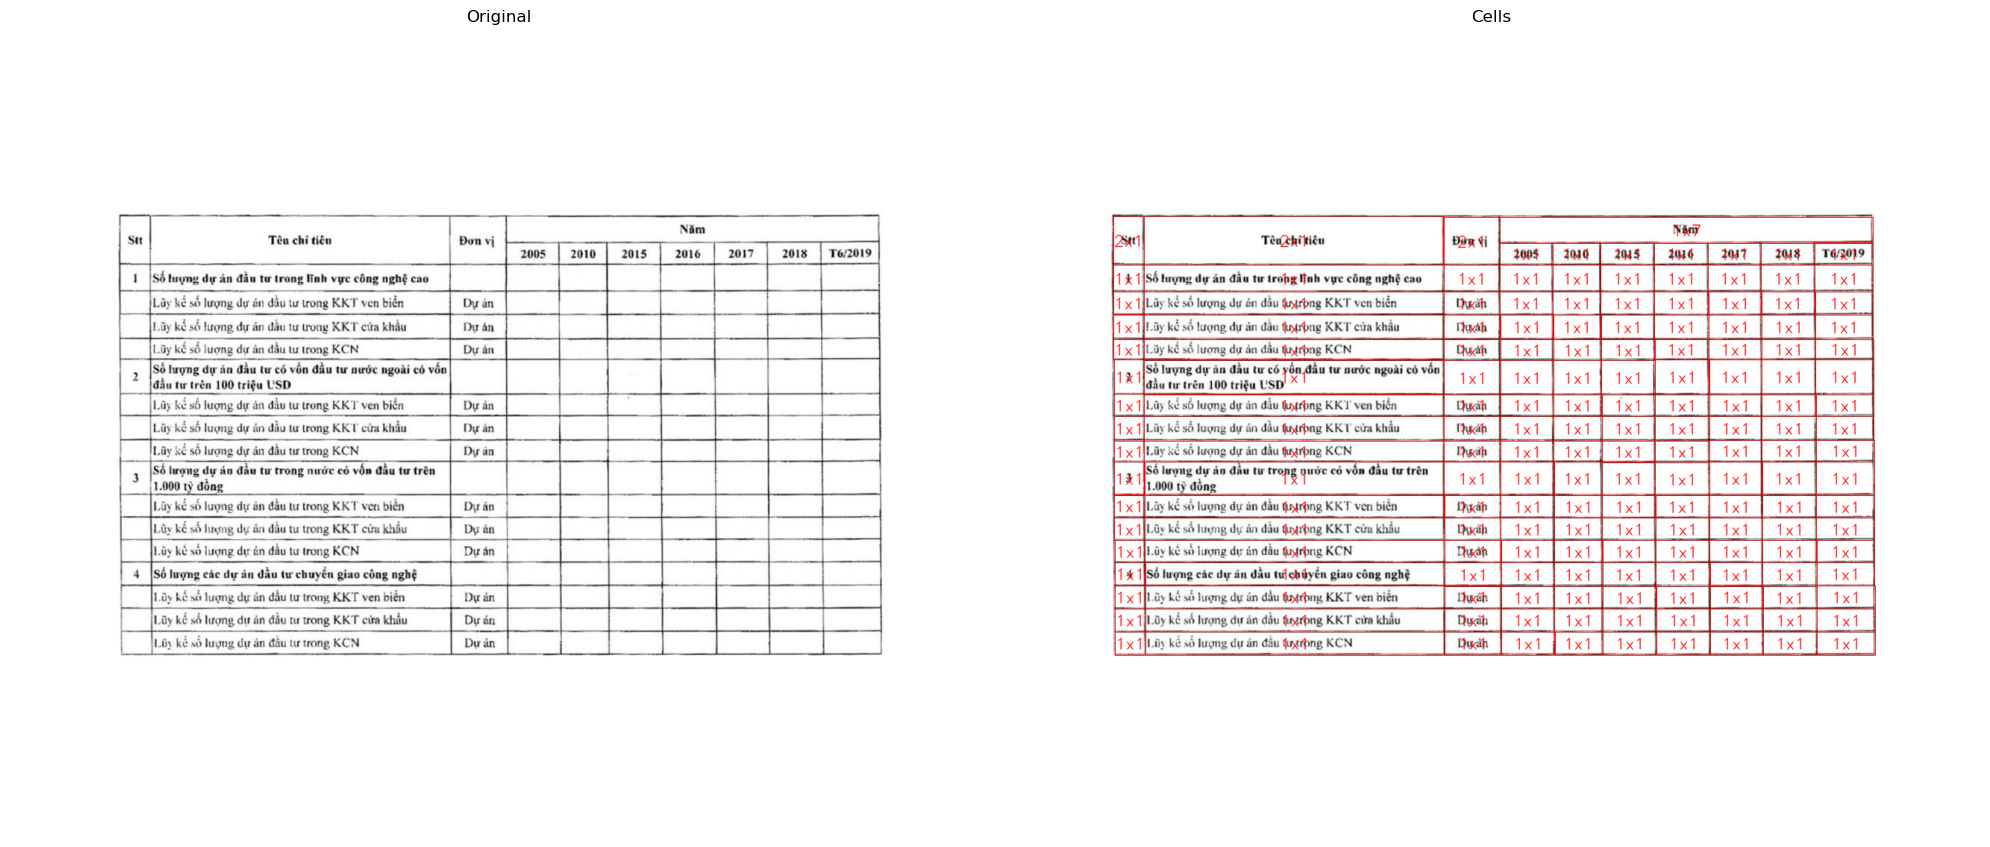

In [20]:
#@title Tạo các ô bảng từ các điểm giao đã được phân theo hàng và cột

def create_cells(rows, columns):
    """
    Tạo các ô bảng từ các điểm giao đã được phân theo hàng và cột.

    Tham số:
    - rows: Danh sách các hàng.
    - columns: Danh sách các cột.

    Trả về:
    - cells: Danh sách các ô bảng.
    Với mỗi ô bảng, lưu trữ các thông tin sau:
        - bbox: Bounding box của ô bảng.
        - row_span: Số hàng của ô bảng.
        - col_span: Số cột của ô bảng.
        - row: Vị trí hàng của ô bảng.
        - col: Vị trí cột của ô bảng.
    """
    cells = []

    for row_index in range(len(rows)-1):
        for top_left_index in range(len(rows[row_index]) - 1):
            top_left = rows[row_index][top_left_index]
            # Tìm cột của top_left
            top_left_col_index = 0
            for top_left_col_index in range(len(columns)):
                if abs(columns[top_left_col_index][0][0] - top_left[0]) < 10:
                    break
            # duyệt qua cột vừa tìm được và tìm bottom_left
            lower_left = list(filter(lambda c: c[1] > top_left[1], columns[top_left_col_index]))
            if len(lower_left) == 0: continue
            bottom_left = lower_left[0]
            for top_right_index in range(top_left_index + 1, len(rows[row_index])):
                top_right = rows[row_index][top_right_index]
                # Tìm cột của top_right
                top_right_col_index = 0
                for top_right_col_index in range(len(columns)):
                    if abs(columns[top_right_col_index][0][0] - top_right[0]) < 10:
                        break
                # duyệt qua cột vừa tìm được và tìm bottom_left
                lower_right = list(filter(lambda c: c[1] > top_right[1], columns[top_right_col_index]))
                if len(lower_right) == 0: continue
                bottom_right = lower_right[0]
                
                # Xử lý bottom_left và bottom_right không cùng 1 hàng
                bottom_right = (bottom_right[0], max(bottom_left[1], bottom_right[1]))
                bottom_left = (bottom_left[0], max(bottom_left[1], bottom_right[1]))
                # print('top_left',top_left,'top_right', top_right, 'bottom_right', bottom_right)

                # Tìm hàng của bottom_right
                bottom_right_row_index = 0
                for bottom_right_row_index in range(len(rows)):
                    if abs(rows[bottom_right_row_index][0][1] - bottom_right[1]) < 10:
                        break

                # Tạo bbox
                bbox =  (top_left[0], top_left[1], bottom_right[0], bottom_right[1])
                # print(bbox)
                # tính row_span và col_span của bbox
                row_span = bottom_right_row_index - row_index
                col_span = top_right_col_index - top_left_col_index
                # Tạo cell
                cell = {'bbox': bbox, 'row_span': row_span, 'col_span': col_span, 'row':row_index, 'col':top_left_col_index}
                cells.append(cell)
                break
                # return cells
    return cells

cells = create_cells(rows, columns)

# Vẽ văn bản vào trung tâm của các box (ở đây là cell)
def draw_text_in_center(img, text, box):
    x1, y1, x2, y2 = box

    center = (int((x1 + x2) / 2), int((y1 + y2) / 2))
    text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 1)
    text_width = text_size[0]
    text_height = text_size[1]
    text_origin = (center[0] - text_width // 2, center[1] + text_height // 2)

    cv2.putText(img, text, text_origin, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1, cv2.LINE_AA)

def draw_cells(img, cells):
    img = img.copy()
    for index, cell in enumerate(cells, start=1):
        x1, y1, x2, y2 = cell['bbox']
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 1)
        draw_text_in_center(img, f"{cell['row_span']}x{cell['col_span']}", cell['bbox'])
        # cv2.circle(img, center, 5, (255, 0, 255), -1)
    return img

cells_img = draw_cells(image_ok, cells)
display_images_with_labels([(image_ok, "Original"), (cells_img, "Cells")], (1, 2), show_axis=False)

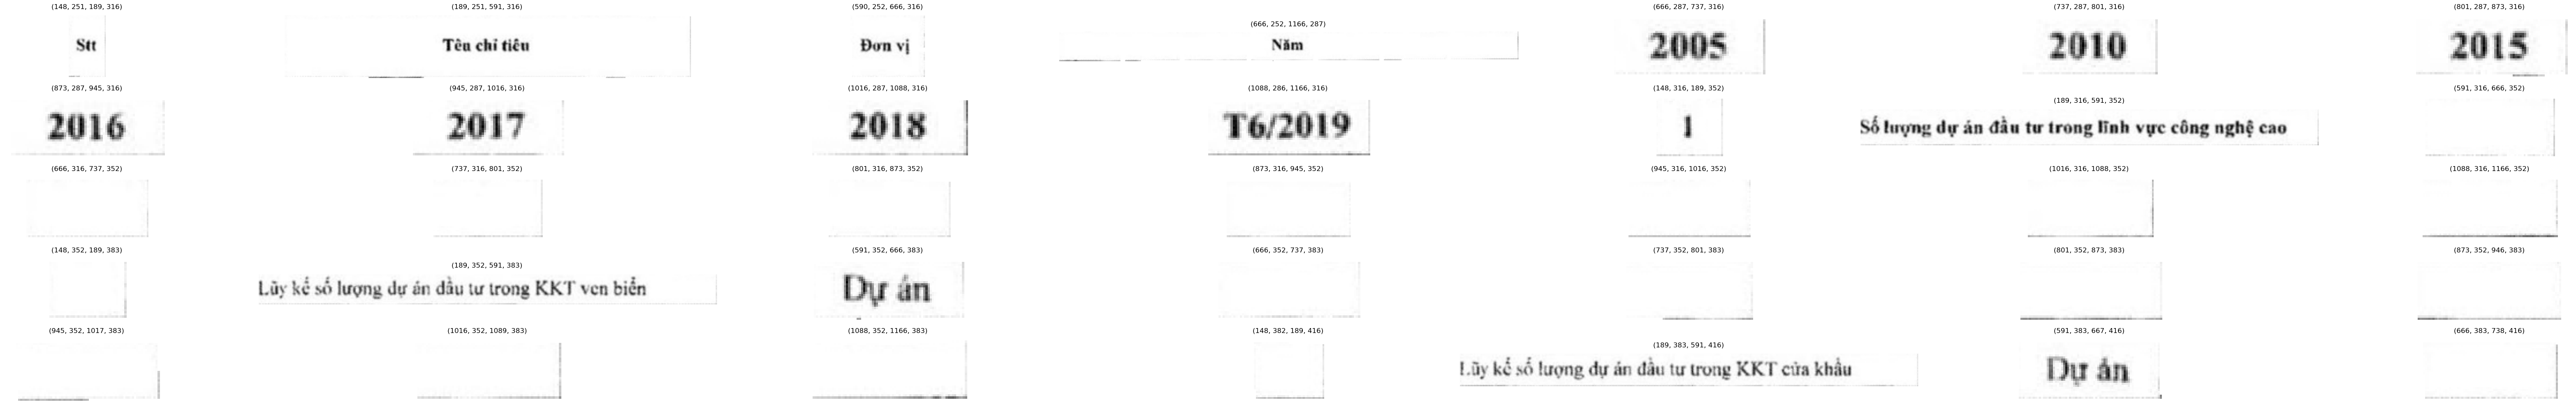

In [10]:
#@title Cắt các ô bảng từ ảnh đã loại bỏ các đường kẻ dọc và ngang
def trim_white(image):
    # Chuyển đổi ảnh sang không gian màu xám
    gray = cv2.cvtColor(cv2.GaussianBlur(image,(5,5),0), cv2.COLOR_BGR2GRAY)

    # Áp dụng ngưỡng nhị phân để tạo mask chỉ chứa các điểm ảnh trắng
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    # Tìm các chỉ số hàng và cột không chứa giá trị 0 (màu trắng) đầu tiên
    rows = np.where(np.any(thresh != 0, axis=1))[0]
    cols = np.where(np.any(thresh != 0, axis=0))[0]

    # Tính toán các giới hạn của bounding box
    y1, y2 = rows[0], rows[-1] + 1
    x1, x2 = cols[0], cols[-1] + 1

    # Cắt và trả về phần ảnh đã được trim
    trimmed_image = image[y1:y2, x1:x2]

    # Thêm 20 pixel vào mỗi cạnh để tránh việc cắt bớt các ký tự
    trimmed_image = cv2.copyMakeBorder(trimmed_image, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=(255, 255, 255))

    # resize về width = 1000
    scale_percent = 1000 / trimmed_image.shape[1]
    width = int(trimmed_image.shape[1] * scale_percent)
    height = int(trimmed_image.shape[0] * scale_percent)
    trimmed_image = cv2.resize(trimmed_image, (width, height), interpolation=cv2.INTER_AREA)

    return trimmed_image

cells_imgs = []
for cell in cells:
    x1,y1,x2,y2 = cell['bbox']
    cropped_image = image_removed[int(y1):int(y2), int(x1):int(x2)]
    img = cropped_image #trim_white(cropped_image)
    cells_imgs += [(img, cell['bbox'])]

display_images_with_labels(cells_imgs[:35], layout = (5, 7), size = (10, 2), show_axis=False)

In [11]:
#@title Cài đặt thư viện nhận diện văn bản
#Kiểm tra hiện tại đã cài đặt thư viện hay chưa
try:
    from vietocr.tool.predictor import Predictor
    print("Đã cài đặt thư viện nhận diện văn bản")
except ModuleNotFoundError:
    print("Đang cài đặt thư viện nhận diện văn bản...")
    ! pip install --quiet vietocr
finally:
    from vietocr.tool.predictor import Predictor
    from vietocr.tool.config import Cfg
    config = Cfg.load_config_from_name('vgg_seq2seq')
    # config['weights'] = './weights/transformerocr.pth'
    # config['weights'] = 'https://drive.google.com/uc?id=13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA'
    config['cnn']['pretrained']=False
    config['device'] = 'cpu'
    config['predictor']['beamsearch']=False
    detector = Predictor(config)

Đã cài đặt thư viện nhận diện văn bản


d:\SOFTS\Anacoda\envs\Tensor\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\SOFTS\Anacoda\envs\Tensor\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model weight C:\Users\LHONCH~1\AppData\Local\Temp\vgg_seq2seq.pth exsits. Ignore download!


Năm 1990 1990


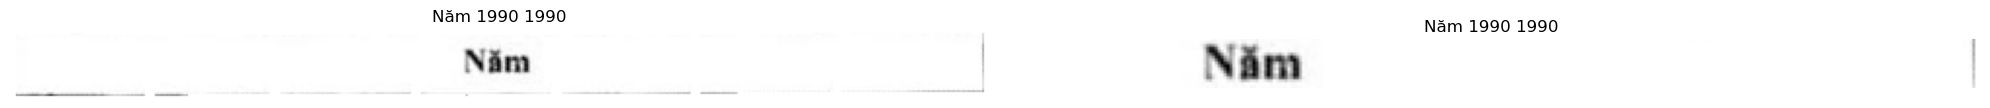

In [12]:
#@title Nhận diện văn bản trong các ô bảng

from PIL import Image

def process_image(image):
    """
    Cắt các dòng văn bản từ ảnh.

    Tham số:
    - image: Ảnh cần xử lý.

    Trả về:
    - images: Danh sách các dòng văn bản đã cắt được.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, bw = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 1))
    dilated = cv2.dilate(bw, kernel, iterations=10) # mở rộng để lấp đầy hàng
    # return [dilated]
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    images = []
    # img_cnt = image.copy()
    for cnt in contours:
        area = cv2.contourArea(cnt)
        x, y, w, h = cv2.boundingRect(cnt)
        if area > 100 and w > h and h > 5:
            # cv2.drawContours(img_cnt, contours, -1, (0, w%255, 0), 2)
            cropped = image[y-3:y+h+3, x:]
            images+=[cropped]
    # return [img_cnt]
    if len(images) == 0:
        return []
    # Tìm độ cao lớn nhất của các ảnh
    max_height = max([img.shape[0] for img in images])
    # xoá các image có độ cao nhỏ hơn nhiều so với max_height
    images = [img for img in images if img.shape[0] > max_height / 2]
    return images[::-1]

def detectText(image):
  """
  Nhận diện văn bản trong ảnh.

  Tham số:
  - image: Ảnh cần nhận diện văn bản.

  Trả về:
  - texts: Danh sách các dòng văn bản đã nhận diện được.
  """
  lines = process_image(image)
  if len(lines) == 0:
    return "", lines
  texts = []
  for line in lines:
    try:
      image = Image.fromarray(cv2.cvtColor(line, cv2.COLOR_BGR2RGB))
      text = detector.predict(image)
      texts.append(text)
    except:
      texts.append('')
  texts = '\n'.join(texts)
  return texts , lines

img = cells_imgs[3][0]
text, lines = detectText(img)
print(text)
display_images_with_labels([(img, text)] + list(zip(lines, text.split('\n'))), (1, len(lines)+1), show_axis=False)

In [13]:
#@title Nhận diện văn bản trong tất cả các ô bảng

texts = []
for cell in cells_imgs:
  img, bbox = cell
  text, lines = detectText(img)
  texts += [text]

print(texts, sep='\n')

['Stt', 'Têu chỉ tiêu', 'Đơn vị', 'Năm 1990 1990', '2005', '2010', '2015', '2016', '2017', '2018', 'T6/2019', '1', 'Số tượng dự án đầu tư trong lĩnh vực công nghệ cao', '', '', '', '', '', '', '', '', '', 'Lũy kế số lượng dự án dầu tư trong KKT ven biển', 'Dự án', '', '', '', '', '', '', '', '', 'Lũy kế số lượng dự ản đầu tư trong KKT cửa khẩu', 'Dự ản', '', '', '', '', '', '', '', '', 'Lũy kể số lượng dự án đầu tư trong KCN', 'Dự án', '', '', '', '', '', '', '', '2', 'Số lượng dự án đầu tư có vốn đầu tư nước ngoài có vốn\nđầu tư trên 100 triệu USD', '', '', 'Substrated', '', '', '', '', '', '', 'Lũy kế số lượng dự án đầu tư trong KKT ven biển chiến', 'Dự án', '', '', '', '', '', '', '', '', 'Lũy kế số lượng dự ản đầu tư trong KKT cửa khẩu', 'Dự án', '', '', '', '', '', '', '', '', 'Lũy kể số lượng dự ản đầu tư trong KCN Trinh Thuy', 'Dự án', '', '', '', '', '', '', '', '3', 'Số lượng dự án đầu tư trong nước có vốn đầu tư trên\n1.000 tỷ đồng', '', '', '', '', '', '', '', '', '', 'Lũy k

In [14]:
import xml.etree.ElementTree as ET
def cells_to_html(cells):

    table = ET.Element("table")
    current_row = -1

    for cell in cells:
        this_row = cell['row']

        attrib = {}
        colspan = cell['col_span']
        if colspan > 1:
            attrib['colspan'] = str(colspan)
        rowspan = cell['row_span']
        if rowspan > 1:
            attrib['rowspan'] = str(rowspan)
        if this_row > current_row:
            current_row = this_row
            if current_row == 0:
                cell_tag = "th"
                row = ET.SubElement(table, "thead")
            else:
                cell_tag = "td"
                row = ET.SubElement(table, "tr")
        tcell = ET.SubElement(row, cell_tag, attrib=attrib)
        tcell.text = cell['cell text']

    return str(ET.tostring(table, encoding="unicode", short_empty_elements=False))

cells_imgs = []
for i in range(len(cells)):
  cells[i]['cell text'] = texts[i]
html = cells_to_html(cells).replace('<thead>','<tr>').replace('</thead>','</tr>').replace('\n',"<br>")
html

'<table><tr><th rowspan="2">Stt</th><th rowspan="2">Têu chỉ tiêu</th><th rowspan="2">Đơn vị</th><th colspan="7">Năm 1990 1990</th></tr><tr><td>2005</td><td>2010</td><td>2015</td><td>2016</td><td>2017</td><td>2018</td><td>T6/2019</td></tr><tr><td>1</td><td>Số tượng dự án đầu tư trong lĩnh vực công nghệ cao</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td></td><td>Lũy kế số lượng dự án dầu tư trong KKT ven biển</td><td>Dự án</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td></td><td>Lũy kế số lượng dự ản đầu tư trong KKT cửa khẩu</td><td>Dự ản</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td></td><td>Lũy kể số lượng dự án đầu tư trong KCN</td><td>Dự án</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td>2</td><td>Số lượng dự án đầu tư có vốn đầu tư nước ngoài có vốn<br>đầu tư trên 100 triệu USD</td><td></td><td></td><td>Substrated</td><td></td><td></td><td></td

In [15]:
from IPython.display import display, HTML

css = """
table {
  border-collapse: collapse;
  border-spacing: 0;
  width: 100%;
  font-family: sans-serif;
}

th, td {
  padding: 8px;
  text-align: center;
  vertical-align: middle;
}

th {
  font-weight: bold;
  font-size: 1.2em;
}

tr:nth-child(even) {
  background-color: rgba(68, 68, 68, 0.2);
}

table th, table td {
  border: 1px solid rgba(68, 68, 68, 0.5);
}
"""
body = """
<div style="display: flex;">
  <div style="flex: 1;">
    <img src="sample/vn1.jpg" alt="Ảnh" style="width: 90%;">
  </div>
  <div style="flex: 1;">""" + html + """</div>
</div>
"""
new_html = '<head><style>'+ css +'</style></head><body>'+ body + '</body>'

display(HTML(new_html))

In [16]:
def recognize(image_path): 
  image = cv2.imread(image_path)
  image_ok, calc_angle = deskew_image(image)
  # image_ok = image
  mask, dots, outImag = recognize_structure(image_ok)
  image_removed = remove_regions(image_ok, mask)
  centers = findCenters(dots)
  rows = split_rows_columns(centers, mode='row')
  columns = split_rows_columns(centers, mode='column')
  cells = create_cells(rows, columns)
  cells_imgs = []
  for cell in cells:
      x1,y1,x2,y2 = cell['bbox']
      cropped_image = image_removed[int(y1):int(y2), int(x1):int(x2)]
      img = cropped_image #trim_white(cropped_image)
      cells_imgs += [(img, cell['bbox'])]
  texts = []
  for cell in cells_imgs:
    img, bbox = cell
    text, lines = detectText(img)
    texts += [text]
  cells_imgs = []
  for i in range(len(cells)):
    cells[i]['cell text'] = texts[i]
  html = cells_to_html(cells).replace('<thead>','<tr>').replace('</thead>','</tr>').replace('\n',"<br>")

  css = """
  table {
    border-collapse: collapse;
    border-spacing: 0;
    width: 100%;
    font-family: sans-serif;
  }

  th, td {
    padding: 8px;
    text-align: center;
    vertical-align: middle;
  }

  th {
    font-weight: bold;
    font-size: 1.2em;
  }

  tr:nth-child(even) {
    background-color: rgba(68, 68, 68, 0.2);
  }

  table th, table td {
    border: 1px solid rgba(68, 68, 68, 0.5);
  }
  """
  body = """
  <div style="display: flex;">
    <div style="flex: 1;">
      <img src='""" + image_path + """' alt="Ảnh" style="width: 90%;">
    </div>
    <div style="flex: 1;">""" + html + """</div>
  </div>
  """
  new_html = '<head><style>'+ css +'</style></head><body>'+ body + '</body>'

  return new_html


prePath = "/content/TableVision/" if IN_COLAB else ""
display(HTML(recognize(prePath + "sample/xx2.jpg")))

In [21]:
display(HTML(recognize(prePath + "sample/L1.jpg")))

In [22]:
display(HTML(recognize(prePath + "sample/L2.jpg")))

In [23]:
display(HTML(recognize(prePath + "sample/L3.jpg")))

In [27]:
display(HTML(recognize(prePath + "sample/L4.jpg")))

In [28]:
display(HTML(recognize(prePath + "sample/L5.jpg")))

In [29]:
display(HTML(recognize(prePath + "sample/L6.jpg")))

In [30]:
display(HTML(recognize(prePath + "sample/L7.jpg")))